In [13]:
# Caso de uso - Detecção de Fraude


In [14]:
# Você tem um banco de dados de clientes, e gostaria de saber, como eles estão conectados uns aos outros

In [17]:
import pandas as pd
import networkx as nx


df = pd.DataFrame({'ID':[1,2,3,4,5,6], 
                   'Primeiro Nome':['Mauricio', 'João', 'Gustavo', 'Bargas', 'André', 'Pedro'], 
                   'Segundo Nome': ['Gomes', 'Ferreira', 'Silva', 'Teodoro', 'Borges', 'Moreira'],
                   'Telefone': ['+61 98190-0200', '+61 99968-1995', '+61 98190-0200', '+61 99961-7272', '+61 99978-1353', '+61 99978-1353'],
                   'Email': ['felix.revert@gmail.com', 'jean.durand@gmail.com', 'j.custom@gmail.com', pd.np.nan, 'j.custom@gmail.com', pd.np.nan]})

column_edge = 'Telefone'
column_ID = 'ID'

data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates() # select columns, remove NaN


In [18]:
data_to_merge

,ID,Telefone
0,1,+61 98190-0200
1,2,+61 99968-1995
2,3,+61 98190-0200
3,4,+61 99961-7272
4,5,+61 99978-1353
5,6,+61 99978-1353


In [20]:
data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge
)

In [21]:
data_to_merge

,ID,Telefone,ID_2
0,1,+61 98190-0200,1
1,1,+61 98190-0200,3
2,3,+61 98190-0200,1
3,3,+61 98190-0200,3
4,2,+61 99968-1995,2
5,4,+61 99961-7272,4
6,5,+61 99978-1353,5
7,5,+61 99978-1353,6
8,6,+61 99978-1353,5
9,6,+61 99978-1353,6


In [22]:
d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]

In [23]:
d

,ID,ID_2,Telefone
1,1,3,+61 98190-0200
2,3,1,+61 98190-0200
7,5,6,+61 99978-1353
8,6,5,+61 99978-1353


In [24]:
d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

In [25]:
d

,ID,ID_2,Telefone
1,1,3,+61 98190-0200
7,5,6,+61 99978-1353


In [26]:
import networkx as nx

G = nx.from_pandas_edgelist(df=d, source=column_ID, target=column_ID+'_2', edge_attr=column_edge)

G.add_nodes_from(nodes_for_adding=df.ID.tolist())

In [27]:
G.nodes()

NodeView((1, 3, 5, 6, 2, 4))

In [28]:
column_edge = 'Email'
column_ID = 'ID'

data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates()

data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge
)

d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]

d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

In [29]:
d

,ID,ID_2,Email
3,3,5,j.custom@gmail.com


In [30]:
# Create the connections in the graph
links_attributes = {tuple(row[[column_ID, column_ID+"_2"]]): {column_edge: row[column_edge]} for i,row in d.iterrows()}

G.add_edges_from(links_attributes) # create the connection, without attribute. Check it with G.get_edge_data(3,5)
nx.set_edge_attributes(G=G, values=links_attributes) # adds the attribute. Check it with G.get_edge_data(3,5)

In [31]:
%matplotlib inline


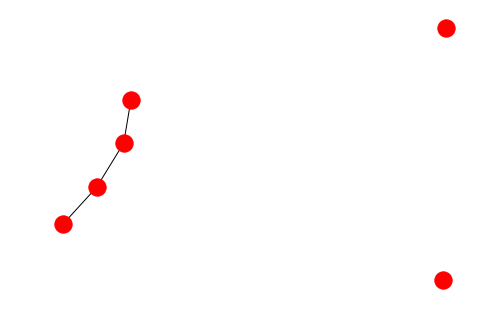

In [32]:
nx.draw(G)


In [33]:
{row[column_ID]:row['Primeiro Nome'] +' '+ row['Segundo Nome'] for i,row in df.iterrows()}

{1: 'Mauricio Gomes',
 2: 'João Ferreira',
 3: 'Gustavo Silva',
 4: 'Bargas Teodoro',
 5: 'André Borges',
 6: 'Pedro Moreira'}

In [34]:
nx.set_node_attributes(G, {row[column_ID]:{'Nome': row['Primeiro Nome'] +' '+ row['Segundo Nome']} for i,row in df.iterrows()})

In [37]:

EDGE_SIZE = {
    'Telefone': 2,
    'Email': 1,
}

EDGE_COLOR = {
    'Telefone': 'purple',
    'Email': 'red',
}

def clean_edge(edge):
    s.edge[edge[0], edge[1]].values()

def c_(list_edges): return [a for a in list_edges if a in list(EDGE_COLOR.keys())]
    
# For nx.Graph()
def edge_sizes(s): return [EDGE_SIZE[c_(list(s.edges[edge[0], edge[1]].keys()))[-1]] for edge in s.edges()] # /!\ multiple links => one size
def edge_colors(s): return [EDGE_COLOR[c_(list(s.edges[edge[0], edge[1]].keys()))[-1]] for edge in s.edges()] # /!\ multiple links => one color

# For nx.MultiDiGraph()
# def edge_sizes(s): return [EDGE_SIZE[s.edge[edge[0]][edge[1]][0]['label']] for edge in s.edges()] # /!\ multiple links => one size
# def edge_colors(s): return [EDGE_COLOR[s.edge[edge[0]][edge[1]][0]['label']] for edge in s.edges()] # /!\ multiple links => one color

def draw(s):
    pos = nx.spring_layout(s, scale=0.5)
    node_labels = dict((n,d['Nome']) for n,d in s.nodes(data=True))
#     labels = {**node_labels, **edge_labels}
    nx.draw(s, pos=pos, width=edge_sizes(s), edge_color=edge_colors(s), alpha=0.8, arrows=False, node_color='lightgrey', node_size=400,
            labels=node_labels, 
            font_color='black', font_size=8, font_weight='bold',
           )
    edge_labels = dict(((u,v),list(d.values())[0]) for u,v,d in G.edges(data=True))
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size=8)

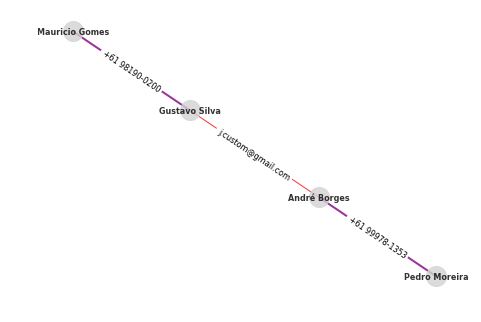

In [38]:
draw(nx.ego_graph(G=G, n=1, radius=3))
